In [6]:
import os, sys
import numpy as np
import tensorflow as tf

In [8]:
# 일관된 출력을 위해 유사난수 초기화
# def reset_graph(seed=42):
#     tf.reset_default_graph()
#     tf.set_random_seed(seed)
#     np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
# matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

In [9]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## Undercomplete Linear 오토인코더로 PCA 구현하기

In [1]:
# 3D 데이터셋을 만듦
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

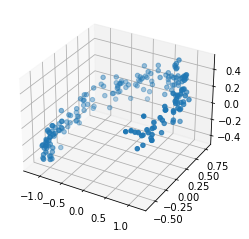

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2])
plt.show()

In [4]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(3,)))
model.add(Dense(2, activation='linear'))
model.add(Dense(3, activation='linear'))

model.compile(optimizer=Adam(lr=0.01), loss='mse', metrics=['accuracy'])

In [6]:
model.fit(X_train, X_train, epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 0.9719 - accuracy: 0.3053
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 0.8251 - accuracy: 0.3582
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 0.7447 - accuracy: 0.3487
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 0.7081 - accuracy: 0.2985
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.3532
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 0.5058 - accuracy: 0.4131
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 0.4418 - accuracy: 0.4194
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 0.3755 - accuracy: 0.3841
Epoch 9/100
4/4 [==============================] - 0s 1000us/step - loss: 0.3301 - accuracy: 0.3965
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.4017
Epoch 11/100
4/4 [========

In [7]:
pca_val = model.predict(X_test)

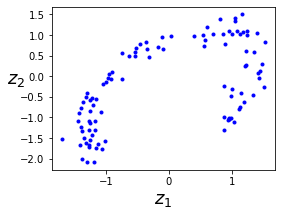

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(pca_val[:,0], pca_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked 오토인코더

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

(train_X, train_y),(test_X, test_y) = mnist.load_data()
train_X = train_X.astype(np.float32).reshape(-1, 28*28) / 255.0
test_X = test_X.astype(np.float32).reshape(-1, 28*28) / 255.0

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

model = Sequential()
model.add(Input(28*28))
model.add(Dense(360, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(128, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(360, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(28*28, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))

In [3]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.01), loss="mse", metrics=["mse"])

In [4]:
model.fit(train_X, train_X, batch_size=150, epochs=5, verbose=1)

Epoch 1/5
400/400 [==============================] - 4s 8ms/step - loss: 0.3948 - mse: 0.1688
Epoch 2/5
400/400 [==============================] - 3s 7ms/step - loss: 0.0490 - mse: 0.0170
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0327 - mse: 0.0158
Epoch 4/5
400/400 [==============================] - 3s 7ms/step - loss: 0.0314 - mse: 0.0160
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0315 - mse: 0.0164


In [5]:
pred = model.predict(test_X)

7


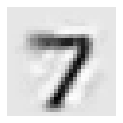

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(pred[0,].reshape(28,28), cmap="Greys", interpolation="nearest")
plt.axis("off")
print(test_y[0])

2


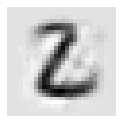

In [7]:
plt.figure(figsize=(2,2))
plt.imshow(pred[1,].reshape(28,28), cmap="Greys", interpolation="nearest")
plt.axis("off")
print(test_y[1])

## 가중치 묶기

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

(train_X, train_y),(test_X, test_y) = mnist.load_data()
train_X = train_X.astype(np.float32).reshape(-1, 28*28) / 255.0
test_X = test_X.astype(np.float32).reshape(-1, 28*28) / 255.0

In [2]:
# N-L+1 번째 layer의 가중치 W = L 번째 layer의 가중치 T
import tensorflow as tf

class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        # 가중치 W는 입력 dense 가중치를 쓰기 때문에 학습가능한 bias 변수만 만든다.
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.backend import transpose

dense1 = Dense(360, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))
dense2 = Dense(128, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))
encoder = Sequential([
    Input(28*28),
    dense1,
    dense2,
])

decoder = Sequential([
    DenseTranspose(dense2, activation='elu'),
    DenseTranspose(dense1, activation='elu'),
])
model = Sequential([encoder, decoder])

In [4]:
from tensorflow.keras.optimizers import Adam
 
model.compile(optimizer=Adam(lr=0.01), loss="mse", metrics=["mse"])

In [5]:
model.fit(train_X, train_X, batch_size=150, epochs=5, verbose=1)

Epoch 1/5
400/400 [==============================] - 3s 7ms/step - loss: 0.2501 - mse: 0.1651
Epoch 2/5
400/400 [==============================] - 3s 7ms/step - loss: 0.0359 - mse: 0.0119
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0250 - mse: 0.0104
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0230 - mse: 0.0105
Epoch 5/5
400/400 [==============================] - 3s 7ms/step - loss: 0.0226 - mse: 0.0106


In [6]:
pred = model.predict(test_X)

7


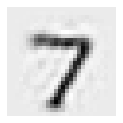

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(pred[0,].reshape(28,28), cmap="Greys", interpolation="nearest")
plt.axis("off")
print(test_y[0])

In [8]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 360)               282600    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               46208     
Total params: 328,808
Trainable params: 328,808
Non-trainable params: 0
_________________________________________________________________


In [9]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_transpose (DenseTransp (None, 360)               46568     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               283384    
Total params: 329,952
Trainable params: 329,952
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               328808    
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               329952    
Total params: 329,952
Trainable params: 329,952
Non-trainable params: 0
_________________________________________________________________


## Denoising 오토인코더

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

(train_X, train_y),(test_X, test_y) = mnist.load_data()
train_X = train_X.astype(np.float32).reshape(-1, 28*28) / 255.0
test_X = test_X.astype(np.float32).reshape(-1, 28*28) / 255.0

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GaussianNoise, Dropout

model = Sequential()
model.add(Input(28*28))
# model.add(GaussianNoise(stddev=0.01))
model.add(Dropout(0.3))
model.add(Dense(360, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(128, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(360, activation='elu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(28*28, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001)))

In [3]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.01), loss="mse", metrics=["mse"])

In [4]:
model.fit(train_X, train_X, batch_size=150, epochs=5)

Epoch 1/5
400/400 [==============================] - 4s 8ms/step - loss: 0.4905 - mse: 0.2408
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0727 - mse: 0.0231
Epoch 3/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0416 - mse: 0.0206
Epoch 4/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0362 - mse: 0.0211
Epoch 5/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0353 - mse: 0.0215


In [5]:
pred = model.predict(test_X)

7


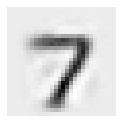

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(pred[0,].reshape(28,28), cmap="Greys", interpolation="nearest")
plt.axis("off")
print(test_y[0])

## CAE를 이용한 노이즈 제거

In [1]:
from tensorflow.python.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
# CNN에서 사용하기 위한 형태 변환
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
# 이미지를 0~1의 범위로 정규화
x_train = x_train/255.
x_test = x_test/255.

In [2]:
def make_masking_noise_data(data_x, percent=0.1) :
    size = data_x.shape
    masking = np.random.binomial(n=1, p=percent, size=size)
    return data_x * masking

x_train_masked = make_masking_noise_data(x_train)
x_test_masked = make_masking_noise_data(x_test)

In [3]:
def make_gaussian_noise_data(data_x, scale=0.8) :
    gaussian_data_x = data_x + np.random.normal(loc=0, scale=scale, size=data_x.shape)
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1)
    return gaussian_data_x

x_train_gauss = make_gaussian_noise_data(x_train)
x_test_gauss = make_gaussian_noise_data(x_test)

In [4]:
from IPython.display import display_png
from tensorflow.keras.preprocessing.image import array_to_img

display_png(array_to_img(x_train[0]))
display_png(array_to_img(x_train_gauss[0]))
display_png(array_to_img(x_train_masked[0]))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D

autoencoder = Sequential()

# Encoder 부분
autoencoder.add(Conv2D (16, (3,3), 1, activation='relu', padding='same', input_shape=(28,28,1)))
autoencoder.add(MaxPooling2D((2,2), padding='same'))
autoencoder.add(Conv2D(8, (3,3), 1, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

# Decoder부분
autoencoder.add(Conv2D(8, (3,3), 1, activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
# 출력 데이터의 채널을 1로 하기 위해
autoencoder.add(Conv2D(1, (3,3), 1, activation='relu', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
initial_weights = autoencoder.get_weights()

In [11]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)       

In [12]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
autoencoder.fit(
    x_train_gauss,     # 입력 : 가우시안 노이즈 데이터
    x_train,           # 정답 : 원래 이미지
    epochs=10,         # 학습할 에폭 수
    batch_size=20,     # 배치 사이즈
    shuffle=True       # 데이터를 셔플한다
    )

Epoch 1/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.2147
Epoch 2/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1949
Epoch 3/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1900
Epoch 4/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1805
Epoch 5/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1776
Epoch 6/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1746
Epoch 7/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1753
Epoch 8/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.1704
Epoch 9/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.1711
Epoch 10/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1699


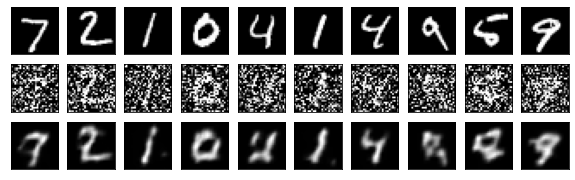

In [14]:
import matplotlib.pyplot as plt

gauss_preds = autoencoder.predict(x_test_gauss)

plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplot(3, 10, i+11)
    plt.imshow(x_test_gauss[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplot(3, 10, i+21)
    plt.imshow(gauss_preds[i], cmap='gray')
    plt.xticks([]), plt.yticks([])

plt.show()

In [15]:
# 가우스 노이즈 데이터로 학습한 모델의 예측
gauss_preds = autoencoder.predict(x_test_gauss)

# 마스킹 이미지, CAE 모델, 원래 이미지 비교
for i in range(10) :
    display_png(array_to_img(x_test[i]))
    display_png(array_to_img(x_test_gauss[i]))
    display_png(array_to_img(gauss_preds[i]))
    print('-'*25)

-------------------------


-------------------------


-------------------------


-------------------------


-------------------------


-------------------------


-------------------------


-------------------------


-------------------------


-------------------------


In [16]:
# 컴파일 직후 취득한 가중치를 다시 set_weights를 이용해서 먼저 저장해둔 initial_weights로 초기화
autoencoder.set_weights(initial_weights)

# 학습
autoencoder.fit(
    x_train_masked,    # 입력 : 마스킹 노이즈 데이터
    x_train,           # 정답 : 원래 이미지
    epochs=10,          # 학습할 에폭 횟수
    batch_size=20,     # 배치 사이즈
    shuffle=True       # 데이터를 셔플
)

Epoch 1/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2319
Epoch 2/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2179
Epoch 3/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2129
Epoch 4/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2177
Epoch 5/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2062
Epoch 6/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2117
Epoch 7/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2050
Epoch 8/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.2168
Epoch 9/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.2096
Epoch 10/10
3000/3000 [==============================] - 19s 6ms/step - loss: 0.2004


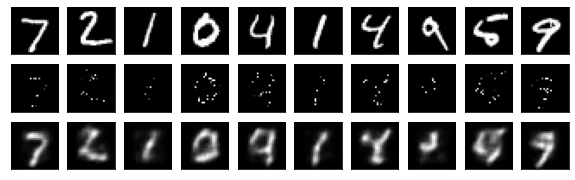

In [22]:
import matplotlib.pyplot as plt

masked_preds = autoencoder.predict(x_test_masked)

plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplot(3, 10, i+11)
    plt.imshow(x_test_masked[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplot(3, 10, i+21)
    plt.imshow(masked_preds[i], cmap='gray')
    plt.xticks([]), plt.yticks([])

plt.show()

In [18]:
# 마스킹 노이즈 데이터로 학습한 모델 예측
masked_preds = autoencoder.predict(x_test_masked)

# 마스킹 이미지, CAE 모델, 원래 이미지 비교
for i in range(10) :
    display_png(array_to_img(x_test[i]))
    display_png(array_to_img(x_test_masked[i]))
    display_png(array_to_img(masked_preds[i]))
    print('*'*25)

*************************


*************************


*************************


*************************


*************************


*************************


*************************


*************************


*************************


*************************


## 자동 채색

In [9]:
import glob
import os
import math

data_path = 'images/colorize'
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))

val_n_sample = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1)
train_n_sample = len(data_lists) - val_n_sample - test_n_sample

val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample:val_n_sample + test_n_sample]
train_lists = data_lists[val_n_sample + test_n_sample : train_n_sample + val_n_sample + test_n_sample]

In [10]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img_size = 224 

def rgb2lab(rgb) :
    assert rgb.dtype == 'uint8'
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

def lab2rgb(lab) :
    assert lab.dtype == 'uint8'
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def get_lab_from_data_list(data_list) :
    x_lab = []
    for f in data_list :
        rgb = img_to_array(
            load_img(f, target_size=(img_size, img_size))
        ).astype(np.uint8)
        lab = rgb2lab(rgb)
        x_lab.append(lab)
    return np.stack(x_lab)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import GaussianNoise, Dropout

autoencoder = Sequential()
# Encoder
autoencoder.add(
    Conv2D(
        32, (3, 3), (1, 1),
        activation = 'relu',
        padding = 'same',
        input_shape = (224, 224, 1)
    )
)
autoencoder.add(
    Conv2D(
        64, (3, 3), (2, 2),
        activation = 'relu',
        padding = 'same'
    )
)
autoencoder.add(
    Conv2D(
        128, (3, 3), (2, 2),
        activation = 'relu',
        padding = 'same'
    )
)
autoencoder.add(
    Conv2D(
        256, (3, 3), (2, 2),
        activation = 'relu',
        padding = 'same'
    )
)

# Decoder
autoencoder.add(
    Conv2DTranspose(
        128, (3, 3), (2, 2),
        activation = 'relu',
        padding = 'same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        64, (3, 3), (2, 2),
        activation = 'relu',
        padding = 'same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        32, (3, 3), (2, 2),
        activation = 'relu',
        padding = 'same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        2, (1, 1), (1, 1),
        activation = 'relu',
        padding = 'same'
    )
)
autoencoder.compile(optimizer='adam', loss = 'mse')
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 224, 224, 32)     

In [12]:
def generator_with_preprocessing(data_list, batch_size, shuffle=True) :
    while True :
        if shuffle :
            np.random.shuffle(data_list)
        for i in range(0, len(data_list), batch_size) :
            batch_list = data_list[i:i + batch_size]
            batch_lab = get_lab_from_data_list(batch_list)
            batch_l = batch_lab[:, :, :, 0:1]
            batch_ab = batch_lab[:, :, :, 1:]
            yield (batch_l, batch_ab)

In [13]:
batch_size = 30

train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True)
val_gen = generator_with_preprocessing(val_lists, batch_size)
test_gen = generator_with_preprocessing(test_lists, batch_size)

train_steps = math.ceil(len(train_lists)/batch_size)
val_steps = math.ceil(len(val_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9362402541059985933
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6246629376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17222169259039380277
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [15]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
autoencoder.fit(train_gen, 
                steps_per_epoch=train_steps, epochs=100, 
                validation_data=val_gen, validation_steps=val_steps
)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 20534.5605

In [ ]:
preds = autoencoder.predict_generator(test_gen, steps=test_steps, verbose=0)

x_test = []
y_test = []
for i, (l, ab) in enumerate(generator_with_preprocessing(test_lists, batch_size)) :
    x_test.append(l)
    y_test.append(ab)
    if i == (test_steps - 1) :
        break
        
x_test = np.vstack(x_test)
y_test = np.vstack(y_test)

In [ ]:
test_preds_lab = np.concatenate((x_test, preds), 3).astype(np.uint8)

test_preds_rgb = []
for i in range(test_preds_lab.shape[0]) :
    preds_rgb = lab2rgb(test_preds_lab[i, :, :, :])
    test_preds_rgb.append(preds_rgb)
test_preds_rgb = np.stack(test_preds_rgb)

In [ ]:
from IPython.display import display_png
from PIL import Image, ImageOps


for i in range(test_preds_rgb.shape[0]):
    gray_image = ImageOps.grayscale(array_to_img(test_preds_rgb[i]))
    display_png(gray_image)
    display_png(array_to_img(test_preds_rgb[i]))
    print('-'*25)
    if i == 20:
        break